# Visualize Predetermined Acquisitions
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        try:
            keys = tuple(obj.keys())
            if keys in __namedtuples:
                nt = __namedtuples[keys]
            else:
                nt = namedtuple(type_name, keys)
                __namedtuples[keys] = nt
            return nt(*(to_namedtuple(v, "type_" + k) for k, v in obj.items()))
        except ValueError:
            return {k: to_namedtuple(v, f"{type_name}_{i}") for i, (k, v) in enumerate(obj.items())}
    if isinstance(obj, list):
        item_type_name = "element_" + type_name 
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = "element_" + type_name 
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = "element_" + type_name 
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
import torch

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan, torch])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
#results = load_laaos_files("./results/cifar10_coreset_pig_bad_golden")
#esults = load_laaos_files("./results/cifar10_coreset_pig_golden_workshop_pool_set")
results = load_laaos_files("./results/predetermined_acquisitions_mnist")

In [ ]:
original_result = to_namedtuple(torch.load("extracted_scores_results.tpickle"), "Results")

In [ ]:
get_any(results).config

_typeConfig(seed=8, experiment_data_config=_typeExperimentDataConfig(id_dataset_name='MNIST', id_repetitions=1, initial_training_set_size=20, validation_set_size=4096, validation_split_random_state=0, evaluation_set_size=0, add_dataset_noise=False, ood_dataset_config=None), acquisition_size=5, max_training_epochs=120, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, device='cuda', acquisition_function='batchbald_redux.acquisition_functions.BALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_trainer_factory='batchbald_redux.models.MnistModelTrainer', ensemble_size=2, temperature=0.0, epig_bootstrap_type='BootstrapType.NO_BOOTSTRAP', epig_bootstrap_factor=1.0, epig_dtype=torch.float64, disable_training_augmentations=False, cache_explicit_eval_model=False)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,4,1637877605
1,1,1637877654
2,2,1637877630
3,4,1637856852
4,1,1637856877
5,3,1637856827
6,3,1637877582
7,0,1637877599
8,2,1637856804
9,0,1637856820


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

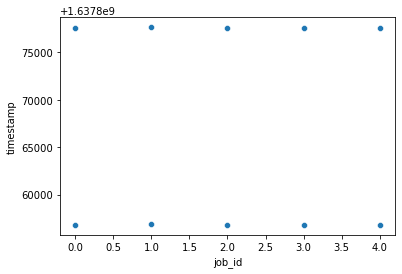

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(5, 10)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    predetermined_120 = "_120" in file
    print(predetermined_120)

    # It is 1, ignore config value!
    acquisition_size = 1
    
    acquisition_function = result.config.acquisition_function
    if acquisition_function.startswith("batchbald_redux.acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    elif acquisition_function.startswith("batchbald_redux.baseline_acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.baseline_acquisition_functions.") :]
        
    num_pool_samples = result.config.num_pool_samples
    
    seed = result.config.seed

    initial_set_size = len(result.initial_training_set_indices)

    for i, step in enumerate(result.active_learning_steps):
        if not hasattr(step, "evaluation_metrics"):
            break
        training_set_size = (120 if predetermined_120 else 20) + i * acquisition_size
        accuracy = step.evaluation_metrics.accuracy
        nll = step.evaluation_metrics.crossentropy

        experiment_data.append(
            dict(
                result_type="Predetermined (from 120)" if predetermined_120 else "Predetermined (from 20)",
                acquisition_function=acquisition_function,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
                training_set_size=training_set_size,
                accuracy=accuracy,
                nll=nll,
                seed=seed,
            )
        )

True
True
True
False
False
False
True
True
False
False


In [ ]:
# It is 1, ignore config value!
acquisition_size = 1

acquisition_function = "BALD"        
num_pool_samples = 100

seed = -1

initial_set_size = 20

for i, step in enumerate(original_result.active_learning_steps):
    if not hasattr(step, "evaluation_metrics"):
        break
    training_set_size = 20 + i * acquisition_size
    accuracy = step.evaluation_metrics.accuracy
    nll = step.evaluation_metrics.crossentropy

    experiment_data.append(
        dict(
            result_type="BALD",
            acquisition_function=acquisition_function,
            acquisition_size=acquisition_size,
            num_pool_samples=num_pool_samples,
            training_set_size=training_set_size,
            accuracy=accuracy,
            nll=nll,
            seed=seed,
        )
    )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,result_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,nll,seed
0,Predetermined (from 120),BALD,1,100,120,0.9283,0.255401,8
1,Predetermined (from 120),BALD,1,100,121,0.9278,0.271645,8
2,Predetermined (from 120),BALD,1,100,122,0.9304,0.265151,8
3,Predetermined (from 120),BALD,1,100,123,0.9282,0.279244,8
4,Predetermined (from 120),BALD,1,100,124,0.9266,0.276862,8
...,...,...,...,...,...,...,...,...
3226,BALD,BALD,1,100,246,0.9598,tensor(0.1952),-1
3227,BALD,BALD,1,100,247,0.9631,tensor(0.1817),-1
3228,BALD,BALD,1,100,248,0.9599,tensor(0.2025),-1
3229,BALD,BALD,1,100,249,0.9590,tensor(0.2420),-1


In [ ]:
#df.to_pickle("plots_data/cifar10_coreset_pig_golden_workshop_pool_set.pkl")

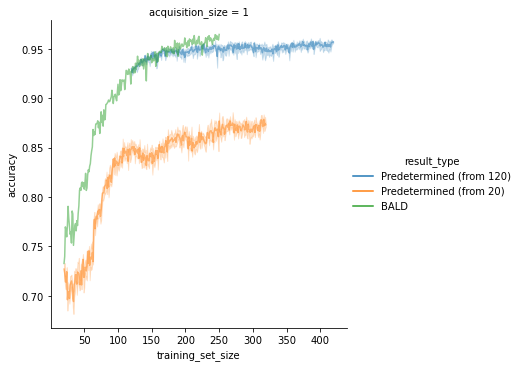

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="result_type",
    #data=df[df.acquisition_function != "CoreSetPIGBALD"],
    data=df,
    kind="line",
    height=5,
    alpha=0.5
)

grd.fig.patch.set_alpha(1)